In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

In [6]:
SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 22
plt.rc('font', size=SMALL_SIZE, family = "Nimbus Roman")          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
# plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [17]:
# load embeddings
dataset_name = "amazon-book"
with open(f"pickles/lgn-predictions-{dataset_name}.pickle", "rb") as pickleFile:
    predictions = pickle.load(pickleFile)
m, d = predictions["item embeddings"].shape
print(m, d)

91599 64


In [18]:
# load interactions
item_popularities = {idx: 0 for idx in range(m)}

train_file = f"LightGCN-PyTorch/data/{dataset_name}/train.txt"
interactions = {}
with open(train_file) as f:
    for l in f.readlines():
        if len(l) > 0:
            l = l.strip('\n').split(' ')
            items = [int(i) for i in l[1:]]
            for idx in items:
                item_popularities[idx] += 1
            interactions[int(l[0])] = items

done


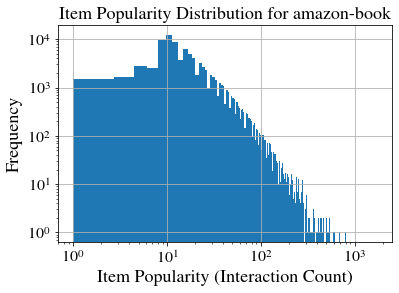

In [19]:
fig, ax = plt.subplots()
item_pop_list = np.array([item_popularities[idx] for idx in range(m)])
ax.hist(item_pop_list,
        bins = 1000)
ax.set_yscale("log")
ax.set_xscale("log")

ax.set_xlabel("Item Popularity (Interaction Count)")
ax.set_ylabel("Frequency")
ax.set_title(f"Item Popularity Distribution for {dataset_name}")
ax.grid()
print("done")

Text(0.5, 1.0, 'Item Embedding Norm by Popularity for gowalla')

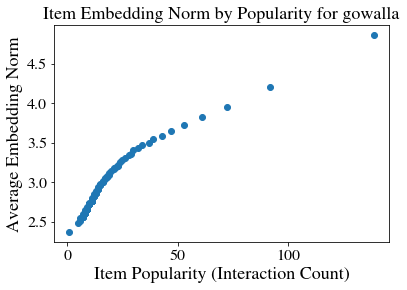

In [8]:
popularities = []
avg_norms = []
for percentile in np.arange(0, 100, 1):
    lower_bound = np.percentile(item_pop_list, percentile)
    upper_bound = np.percentile(item_pop_list, percentile + 1)
    
    indices = np.where((item_pop_list >= lower_bound) & (item_pop_list <= upper_bound))[0]
    norms = [np.linalg.norm(predictions["item embeddings"][idx]) for idx in indices]
    avg_norms.append(np.mean(norms))
    popularities.append(lower_bound)
    
fig, ax = plt.subplots()
ax.scatter(popularities, avg_norms)
ax.set_xlabel("Item Popularity (Interaction Count)")
ax.set_ylabel("Average Embedding Norm")
ax.set_title(f"Item Embedding Norm by Popularity for {dataset_name}")

Text(0.5, 1.0, 'amazon-book')

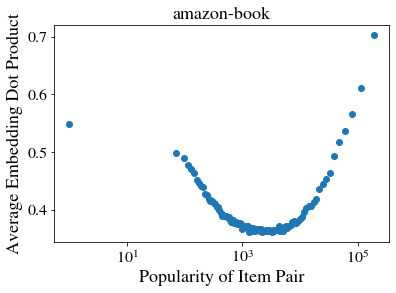

In [20]:
trials = 1000000
popularity_products = []
dot_products = []

users = list(interactions.keys())
rng = np.random.default_rng()
for _ in range(trials):
    user_id = users[rng.choice(len(users))]
    if len(interactions[user_id]) < 2:
        continue
    item_pair = rng.choice(interactions[user_id], size=2, replace=False)
    popularity_products.append(item_popularities[item_pair[0]] * item_popularities[item_pair[1]])
    
    v_i = predictions["item embeddings"][item_pair[0]]
    v_j = predictions["item embeddings"][item_pair[1]]
    dot_products.append(np.dot(v_i, v_j))
    dot_products[-1] /= (np.linalg.norm(v_i) * np.linalg.norm(v_j))

dot_products = np.array(dot_products)
pair_popularity_buckets = []
avg_dot_products = []
for percentile in np.arange(0, 100, 1):
    lower_bound = np.percentile(popularity_products, percentile)
    upper_bound = np.percentile(popularity_products, percentile + 1)
    
    indices = np.where((popularity_products >= lower_bound) & (popularity_products <= upper_bound))[0]
    avg_dot_products.append(np.mean(dot_products[indices]))
    pair_popularity_buckets.append(lower_bound)
    
fig, ax = plt.subplots()
ax.scatter(pair_popularity_buckets, avg_dot_products)
ax.set_xscale("log")
ax.set_xlabel("Popularity of Item Pair")
ax.set_ylabel("Average Embedding Dot Product")
ax.set_title(dataset_name)